<a href="https://colab.research.google.com/github/nv-hiep/object_detection/blob/main/Step2_Bounding_box_regression_with_Keras%2C_TensorFlow%2C_and_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bounding box regression with Keras, TensorFlow, and Deep Learning

# Connect and authorize google drive with google colab:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/object_detection
!ls

/content/gdrive/My Drive/Colab Notebooks/object_detection
 101_ObjectCategories
 Annotations
'Bounding box regression with Keras, TensorFlow, and Deep Learning.ipynb'
 data_Motorbikes.csv
 model
 plots
 test


# Libraries

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import os
import glob
import time
import csv
import cv2

import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.patches as patches

from PIL import Image
from scipy.io import loadmat


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
from keras.applications import VGG16
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

from google.colab.patches import cv2_imshow

#1. Caltech 101 dataset

## 1.1 Data directories

In [ ]:
# APP_PATH = !pwd
APP_PATH  = '/content/gdrive/My Drive/Colab Notebooks/object_detection'
DAT_DIR   = os.path.join(APP_PATH, 'data')
PREP_DIR  = os.path.join(DAT_DIR, 'prep')
DATA_PATH = os.path.join(DAT_DIR, '101_ObjectCategories')
ANN_PATH  = os.path.join(DAT_DIR, 'Annotations') 

print('Project path: ', APP_PATH)
print('Data path: ', DATA_PATH)
print('Annotation path: ', ANN_PATH)

Project path:  /content/gdrive/My Drive/Colab Notebooks/object_detection
Data path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories
Annotation path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations


In [ ]:
if not os.path.exists(PREP_DIR):
  os.makedirs(PREP_DIR)

In [ ]:
MODEL_PATH = os.path.join(APP_PATH, 'model')
PLOT_PATH  = os.path.join(APP_PATH, 'plots')
TEST_PATH  = os.path.join(APP_PATH, 'test')

print('Model path: ', MODEL_PATH)
print('Plot path: ', PLOT_PATH)
print('Test path: ', TEST_PATH)

if not os.path.exists(MODEL_PATH):
  os.makedirs(MODEL_PATH)

if not os.path.exists(PLOT_PATH):
  os.makedirs(PLOT_PATH)

if not os.path.exists(TEST_PATH):
  os.makedirs(TEST_PATH)

Model path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/model
Plot path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/plots
Test path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/test


##1.2 All labels and annotations

In [ ]:
# subdirectories in 101_ObjectCategories
dirs   = glob.glob( os.path.join(DATA_PATH, '*') )
labels = [x.split('/')[-1] for x in dirs]
print('Number of labels: ', len(labels))
print('Some examples: ', labels)

Number of labels:  102
Some examples:  ['bonsai', 'anchor', 'barrel', 'beaver', 'bass', 'BACKGROUND_Google', 'airplanes', 'ant', 'accordion', 'binocular', 'brontosaurus', 'butterfly', 'brain', 'cellphone', 'chair', 'car_side', 'cannon', 'ceiling_fan', 'buddha', 'camera', 'dollar_bill', 'dalmatian', 'chandelier', 'cup', 'cougar_body', 'crocodile', 'crab', 'cougar_face', 'crayfish', 'crocodile_head', 'Faces_easy', 'ferry', 'dolphin', 'Faces', 'euphonium', 'emu', 'electric_guitar', 'elephant', 'ewer', 'dragonfly', 'garfield', 'headphone', 'grand_piano', 'helicopter', 'flamingo', 'gramophone', 'hedgehog', 'hawksbill', 'flamingo_head', 'gerenuk', 'ibis', 'joshua_tree', 'lobster', 'kangaroo', 'inline_skate', 'lamp', 'ketch', 'llama', 'Leopards', 'laptop', 'Motorbikes', 'metronome', 'okapi', 'nautilus', 'mandolin', 'mayfly', 'lotus', 'octopus', 'menorah', 'minaret', 'saxophone', 'pagoda', 'panda', 'pizza', 'rhino', 'pigeon', 'rooster', 'revolver', 'pyramid', 'platypus', 'schooner', 'stop_sign

In [ ]:
# subdirectories in Annotations
dirs = glob.glob( os.path.join(ANN_PATH, '*') )
anns = [x.split('/')[-1] for x in dirs]
print('Number of Annotations: ', len(anns))
print('Some examples: ', anns)

Number of Annotations:  106
Some examples:  ['progress.mat', 'README', 'README~', 'FeatureDetectionQuality.mat', 'check_progress.mat', 'Airplanes_Side_2', 'ant', 'brain', 'anchor', 'beaver', 'bass', 'binocular', 'bonsai', 'accordion', 'barrel', 'chair', 'butterfly', 'cellphone', 'camera', 'buddha', 'car_side', 'ceiling_fan', 'chandelier', 'cannon', 'brontosaurus', 'cougar_face', 'cougar_body', 'dolphin', 'crocodile', 'dalmatian', 'crab', 'cup', 'dollar_bill', 'crocodile_head', 'crayfish', 'flamingo', 'electric_guitar', 'Faces_2', 'ferry', 'dragonfly', 'ewer', 'Faces_3', 'elephant', 'euphonium', 'emu', 'helicopter', 'gerenuk', 'headphone', 'flamingo_head', 'gramophone', 'hawksbill', 'grand_piano', 'ibis', 'garfield', 'hedgehog', 'llama', 'joshua_tree', 'ketch', 'lotus', 'inline_skate', 'lobster', 'lamp', 'Leopards', 'laptop', 'kangaroo', 'octopus', 'mayfly', 'minaret', 'Motorbikes_16', 'pagoda', 'metronome', 'nautilus', 'okapi', 'menorah', 'mandolin', 'rhino', 'pigeon', 'pizza', 'schoon

##1.3 Label: Motorbikes

In [ ]:
mylabel_img = 'Motorbikes'
mylabel_ann = 'Motorbikes_16'

img_samples = glob.glob( os.path.join(DATA_PATH, mylabel_img, '*') )
print('Number of sample images: ', len(img_samples))
print(img_samples[:5])

ann_samples = glob.glob( os.path.join(ANN_PATH, mylabel_ann, '*') )
print('Number of sample annotations: ', len(ann_samples))
print(ann_samples[:5])

Number of sample images:  798
['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Motorbikes/image_0026.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Motorbikes/image_0020.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Motorbikes/image_0024.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Motorbikes/image_0031.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Motorbikes/image_0010.jpg']
Number of sample annotations:  798
['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/Motorbikes_16/annotation_0093.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/Motorbikes_16/annotation_0061.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/Motorbikes_16/annotation_0039.mat', '/content/gdrive/My Drive/Colab 

Plot some samples

Image shape: (180, 275, 3)
Image shape: (159, 263, 3)
Image shape: (153, 263, 3)
Image shape: (150, 265, 3)


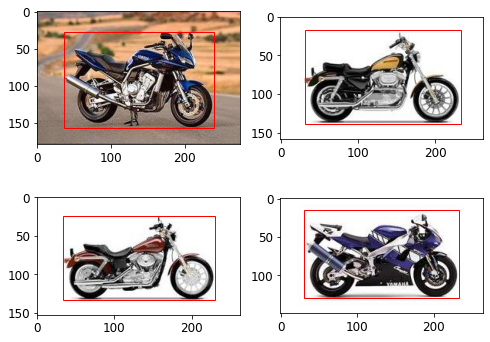

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))
axs = axs.flatten()

for i in range(4):
  ximg   = Image.open(img_samples[i])
  img_id = img_samples[i].split('/')[-1].replace('.jpg', '').replace('image_', '')
  print(f'Image shape: {np.array(ximg).shape}')
  axs[i].imshow(ximg)

  ann_file     = os.path.join(ANN_PATH, mylabel_ann, 'annotation_' + img_id + '.mat')
  (y, h, x, w) = loadmat(ann_file)['box_coord'][0]

  rect = patches.Rectangle( (x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')  
  axs[i].add_patch(rect)

plt.show()

Write image+annottion infor to CSV file

In [ ]:
print(f'Number of samples: {len(img_samples)}')

Number of samples: 798


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/object_detection
!pwd

/content/gdrive/My Drive/Colab Notebooks/object_detection
/content/gdrive/My Drive/Colab Notebooks/object_detection


In [ ]:
def write_to_csv(img_samples, csv_file):
  '''
  Write to a csv file
  '''
  csv_rowlist = [ ['class', 'img_file', 'annotation_file', 'ID', 'shapes', 'height', 'width', 'x_start', 'x_end', 'y_start', 'y_end', 'targets'] ]
  for i in range( len(img_samples) ):
    ximg     = Image.open(img_samples[i])
    img_id   = img_samples[i].split('/')[-1].replace('.jpg', '').replace('image_', '')
    
    ann_file = os.path.join(ANN_PATH, mylabel_ann, 'annotation_' + img_id + '.mat')
    (y_start, y_end, x_start, x_end) = loadmat(ann_file)['box_coord'][0]

    shapes  = np.array(ximg).shape
    targets = [np.round(x_start/float(shapes[1]), 3), np.round(x_end/float(shapes[1]), 3), np.round(y_start/float(shapes[0]), 3), np.round(y_end/float(shapes[0]), 3)]

    row_ = [mylabel_img.lower(), img_samples[i].split('/')[-1], 'annotation_' + img_id + '.mat', '_' + img_id,
            shapes, float(shapes[0]), float(shapes[1]), float(x_start), float(x_end), float(y_start), float(y_end), targets]
    # print( row_ )
    csv_rowlist.append( row_ )

  print( len(csv_rowlist) )
  with open(csv_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerows(csv_rowlist)

In [ ]:
csv_file = 'data_' + mylabel_img + '.csv'
csv_file = os.path.join(PREP_DIR, csv_file)
print(csv_file)
if not os.path.exists( csv_file ):
  write_to_csv(img_samples, csv_file)

/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_Motorbikes.csv


Read infor from CSV file

In [ ]:
df = pd.read_csv(csv_file)

In [ ]:
df.head()

,class,img_file,annotation_file,ID,shapes,height,width,x_start,x_end,y_start,y_end,targets
0,motorbikes,image_0026.jpg,annotation_0026.mat,_0026,"(180, 275, 3)",180.0,275.0,36.0,240.0,27.0,158.0,"[0.131, 0.873, 0.15, 0.878]"
1,motorbikes,image_0020.jpg,annotation_0020.mat,_0020,"(159, 263, 3)",159.0,263.0,31.0,234.0,17.0,139.0,"[0.118, 0.89, 0.107, 0.874]"
2,motorbikes,image_0024.jpg,annotation_0024.mat,_0024,"(153, 263, 3)",153.0,263.0,33.0,230.0,25.0,133.0,"[0.125, 0.875, 0.163, 0.869]"
3,motorbikes,image_0031.jpg,annotation_0031.mat,_0031,"(150, 265, 3)",150.0,265.0,30.0,233.0,15.0,129.0,"[0.113, 0.879, 0.1, 0.86]"
4,motorbikes,image_0010.jpg,annotation_0010.mat,_0010,"(148, 263, 3)",148.0,263.0,32.0,233.0,18.0,127.0,"[0.122, 0.886, 0.122, 0.858]"


In [ ]:
df.dtypes

class               object
img_file            object
annotation_file     object
ID                  object
shapes              object
height             float64
width              float64
x_start            float64
x_end              float64
y_start            float64
y_end              float64
targets             object
dtype: object

In [ ]:
df['targets'] = df['targets'].str.strip('[]').str.split(',').apply(lambda x: [float(i) for i in x])

In [ ]:
targets   = np.array( [x for x in df.targets], dtype='float32')
filenames = np.array( [x for x in df.img_file] )

In [ ]:
print('targets.shape: ', targets.shape)
targets[:3]

targets.shape:  (798, 4)


array([[0.131, 0.873, 0.15 , 0.878],
       [0.118, 0.89 , 0.107, 0.874],
       [0.125, 0.875, 0.163, 0.869]], dtype=float32)

In [ ]:
print('filenames.shape: ', filenames.shape)
filenames[:3]

filenames.shape:  (798,)


array(['image_0026.jpg', 'image_0020.jpg', 'image_0024.jpg'], dtype='<U14')

In [ ]:
# Read images to X
X = []
for xfile in filenames:
  ximg = load_img( os.path.join(DATA_PATH, mylabel_img, xfile), target_size=(224, 224) ) # For the input-size of VGG16
  ximg = img_to_array(ximg)

  X.append(ximg)

In [ ]:
print('Class: ', mylabel_img)
print('Number of images: ', len(X))
print('Shape of a sample image: ', X[0].shape)

Class:  Motorbikes
Number of images:  798
Shape of a sample image:  (224, 224, 3)


In [ ]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(X, dtype='float32')

In [ ]:
data.shape

(798, 224, 224, 3)

In [ ]:
# save to npy file
npy_file = 'data_' + mylabel_img + '.npy'
npy_file = os.path.join(PREP_DIR, npy_file)
np.save(npy_file, data)

#2. Data preprocessing

Use TensorFlow/Keras’ load_img method. This time, we ensure that our image size is 224x 224 pixels for training with VGG16 followed by converting to array format

In [ ]:
# Read images to X
X = []
for xfile in filenames:
  ximg = load_img( os.path.join(DATA_PATH, mylabel_img, xfile), target_size=(224, 224) ) # For the input-size of VGG16
  ximg = img_to_array(ximg)

  X.append(ximg)

In [ ]:
print('Number of images: ', len(X))
print('Shape of a sample image: ', X[0].shape)

Number of images:  798
Shape of a sample image:  (224, 224, 3)


In [ ]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(X, dtype='float32') / 255.

In [ ]:
data.shape

(798, 224, 224, 3)

Training and testing datasets

In [ ]:
split = train_test_split(data, targets, filenames, test_size=0.15,	random_state=42)

In [ ]:
len(split)

6

In [ ]:
# unpack the data split
(X_train_full, X_test) = split[:2]
(y_train_full, y_test) = split[2:4]
(file_train, file_test) = split[4:]

print('X_train_full shape: ', X_train_full.shape)
print('X_test shape', X_test.shape)

X_train_full shape:  (678, 224, 224, 3)
X_test shape (120, 224, 224, 3)


In [ ]:
print('y_train_full shape: ', y_train_full.shape)
print('y_test shape', y_test.shape)

y_train_full shape:  (678, 4)
y_test shape (120, 4)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_valid shape', X_valid.shape)
print('y_train shape: ', y_train.shape)
print('y_valid shape', y_valid.shape)

X_train shape:  (542, 224, 224, 3)
X_valid shape (136, 224, 224, 3)
y_train shape:  (542, 4)
y_valid shape (136, 4)


#3. Model

##3.1 Build model

Use VGG16 model for fine-tuning:

In [ ]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR    = 1.e-4
NUM_EPOCHS = 30
BATCH_SIZE = 32

In [ ]:
# load the VGG16 model, ensuring the head FC layers are left off
# Note: the input-size of VGG16 = (224, 224, 3)
base_vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the training process
base_vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = base_vgg.output
flatten = Flatten()(flatten)

In [ ]:
'''
Initialization	Activation function
Glorot          None, tanh, logistic, softmax
He              ReLU and variants
LeCun           SELU
'''

# construct a fully-connected layer header to output
# the predicted bounding box coordinates: ['x_start_ratio', 'x_end_ratio', 'y_start_ratio', 'y_end_ratio']
bbox_model_head = Dense(units=128, activation='relu', kernel_initializer='he_uniform')(flatten)
bbox_model_head = Dense(units=64, activation='relu', kernel_initializer='he_uniform')(bbox_model_head)
bbox_model_head = Dense(units=32, activation='relu', kernel_initializer='he_uniform')(bbox_model_head)
bbox_model_head = Dense(units=4, activation='sigmoid')(bbox_model_head)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=[base_vgg.input], outputs=[bbox_model_head])

In [ ]:
# initialize the optimizer, compile the model, and show the model # summary
optimizer = Adam(lr=INIT_LR)
model.compile(loss='mse', optimizer=optimizer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

##3.2 Train the model

In [ ]:
# train the network for bounding box regression
print('Training bounding box model...')
H = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
              batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1)

Training bounding box model...
Epoch 1/30
17/17 [==============================] - 31s 1s/step - loss: 0.0693 - val_loss: 0.0082
Epoch 2/30
17/17 [==============================] - 5s 315ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 3/30
17/17 [==============================] - 5s 313ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 4/30
17/17 [==============================] - 5s 312ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 5/30
17/17 [==============================] - 5s 314ms/step - loss: 0.0013 - val_loss: 9.2553e-04
Epoch 6/30
17/17 [==============================] - 5s 313ms/step - loss: 7.8064e-04 - val_loss: 7.9819e-04
Epoch 7/30
17/17 [==============================] - 5s 314ms/step - loss: 7.3501e-04 - val_loss: 7.5503e-04
Epoch 8/30
17/17 [==============================] - 5s 314ms/step - loss: 6.0572e-04 - val_loss: 7.1983e-04
Epoch 9/30
17/17 [==============================] - 5s 314ms/step - loss: 5.9210e-04 - val_loss: 6.9639e-04
Epoch 10/30
17/17 [================

##3.3 Save the model

Saving model...


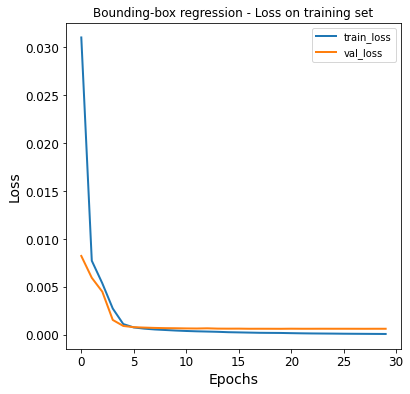

In [ ]:
# serialize the model to disk
print('Saving model...')
model.save( os.path.join(MODEL_PATH, 'model.h5'), save_format='h5')

# plot the model training history
# plt.style.use('seaborn')

plt.figure(figsize=(6,6))

plt.plot(H.history['loss'], label='train_loss', lw=2)
plt.plot(H.history['val_loss'], label='val_loss', lw=2)

plt.title('Bounding-box regression - Loss on training set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.savefig(os.path.join(PLOT_PATH, 'history.png'))

##3.4 Evaluate model

In [ ]:
mse_test = model.evaluate(X_test, y_test)
mse_test

4/4 [==============================] - 9s 3s/step - loss: 5.4648e-04


0.0005464821006171405

In [ ]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = []
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	# define evaluation procedure
	cv = KFold(n_splits=3, random_state=None, shuffle=False)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train_k, X_test_k = X[train_ix], X[test_ix]
		y_train_k, y_test_k = y[train_ix], y[test_ix]

		# fit model
		model.fit(X_train_k, y_train_k, verbose=0, epochs=6)
		# evaluate model on test set
		mse = model.evaluate(X_test_k, y_test_k, verbose=0)
		# store result
		print('>%.7f' % mse)
		results.append(mse)
	return results

In [ ]:
# evaluate model
results = evaluate_model(X_test, y_test)
# summarize performance
print('MSE: %.7f, std: (%.7f)' % (np.mean(results), np.std(results)))

>0.0004859
>0.0001367
>0.0000789
MSE: 0.0002338, std: (0.0001798)


##3.5 Load model

In [ ]:
# load our trained bounding box regressor from disk
print('Loading object detector...')
model = load_model( os.path.join(MODEL_PATH, 'model.h5') )

Loading object detector...


##3.6 Predict

In [ ]:
image = X_test[0]
image = np.expand_dims(image, axis=0)
image.shape

(1, 224, 224, 3)

ID: 0798, Image shape: (175, 261, 3)
ID: 0063, Image shape: (168, 267, 3)
ID: 0103, Image shape: (177, 266, 3)
ID: 0637, Image shape: (196, 261, 3)
ID: 0036, Image shape: (131, 262, 3)
ID: 0754, Image shape: (156, 261, 3)
ID: 0484, Image shape: (154, 261, 3)
ID: 0619, Image shape: (196, 261, 3)
ID: 0224, Image shape: (171, 261, 3)


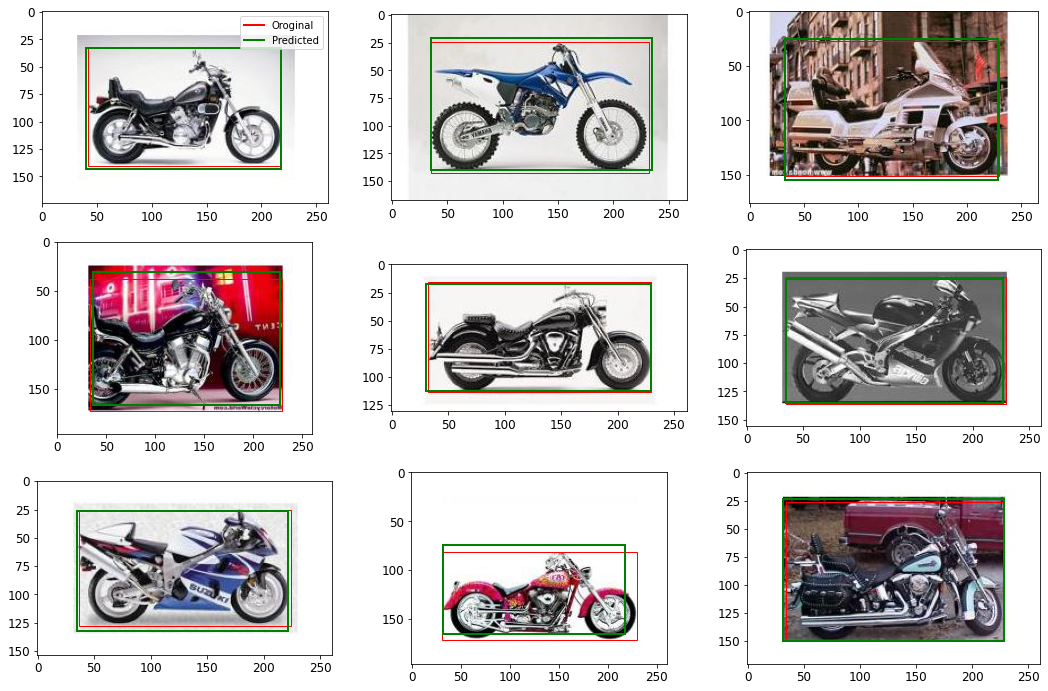

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(18,12))
axs = axs.flatten()

for i in range(9):
  # Predict
  image = X_test[i]
  image = np.expand_dims(image, axis=0)
  preds = model.predict(image)
  (X_start, X_end, Y_start, Y_end) = preds[0]

  # Plot image
  img_path = os.path.join(DATA_PATH, mylabel_img, file_test[i])
  ximg     = Image.open(img_path)
  img_id   = file_test[i].split('/')[-1].replace('.jpg', '').replace('image_', '')
  axs[i].imshow(ximg)

  img_shape = np.array(ximg).shape
  print(f'ID: {img_id}, Image shape: {img_shape}')

  ann_file     = os.path.join(ANN_PATH, mylabel_ann, 'annotation_' + img_id + '.mat')
  (y, h, x, w) = loadmat(ann_file)['box_coord'][0]

  rect = patches.Rectangle( (x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')  
  axs[i].add_patch(rect)

  # scale the predicted bounding box coordinates based on the image dimensions
  (h, w)  = img_shape[:2]
  X_start = int(X_start * w)
  Y_start = int(Y_start * h)
  X_end   = int(X_end * w)
  Y_end   = int(Y_end * h)

  rect = patches.Rectangle( (X_start, Y_start), X_end-X_start, Y_end-Y_start, linewidth=2, edgecolor='g', facecolor='none')  
  axs[i].add_patch(rect)

  if i == 0:
    axs[i].plot([0,0],[0,0], 'r-',lw=2, label='Oroginal')
    axs[i].plot([0,0],[0,0], 'g-',lw=2, label='Predicted')

    axs[i].legend()

plt.show()